In [7]:
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import numpy as np
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import re
from tqdm import tqdm
import pandas as pd
import numpy as np
from tqdm import tqdm
train_data = pd.read_table('ratings_train.txt')[['document','label']]
test_data = pd.read_table('ratings_test.txt')[['document','label']]
data=pd.concat((train_data,test_data),axis=0)
data=data.rename(columns = {'label':'y', 'document' : 'X'})

class 한글처리기:
    def __init__(self,data):
        data['clean_X'] =data['X']
        data['y_name'] = data['y']
        data['encoder_y'] = LabelEncoder().fit_transform(data['y'])
        data['categorical_y'] = list(to_categorical(data['encoder_y']))
        self.data = data
    def ck_m(self):
        print(f'결측치 확인:{self.data.isnull().values.any()}')
        print(f"X 중복 확인:{self.data['X'].nunique(),len(self.data['X'])}\n"
              f"y 중복 확인:{self.data['y'].nunique(),len(self.data['y'])}")

    def 전처리_결과_출력(self, n=1):
        self.data = self.data.drop_duplicates(subset=['X'])
        self.data['clean_X'] = self.data.X.str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]', '')
        self.data['clean_X'] = self.data.clean_X.str.replace('^ +', '')
        self.data['clean_X'] = self.data.clean_X.replace('', np.nan)
        self.data = self.data.dropna(how='any')
        s_w = set(['은', '는', '이', '가', '를', '들', '에게', '의', '을', '도', '으로', '만', '라서', '하다'])
        okt = Okt()
        X_data = []
        for i in tqdm(self.data['clean_X']):
            tk_d = okt.morphs(i)
            end_d = [w for w in tk_d if not w in s_w]
            X_data.append(' '.join(end_d))
        if n==1:
            Y = np.array(self.data['encoder_y'])
        else:
            Y = to_categorical(self.data['encoder_y'])
        X = np.array(X_data)
        x_data, test_x, y_data, test_y = train_test_split(X, Y, test_size=0.3, random_state=0)
        train_x, val_x, train_y, val_y = train_test_split(x_data, y_data, test_size=0.2, random_state=0)
        tk = Tokenizer()
        tk.fit_on_texts(train_x)
        n = len([d for d in sorted(list(tk.word_counts.items()), key=lambda x: x[1]) if d[1] > 4]) + 1
        token = Tokenizer(n)
        token.fit_on_texts(train_x)
        token_train_x = token.texts_to_sequences(train_x)
        token_test_x = token.texts_to_sequences(test_x)
        token_val_x = token.texts_to_sequences(val_x)
        drop_train = [index for index, sentence in enumerate(token_train_x) if len(sentence) < 1]
        drop_test = [index for index, sentence in enumerate(token_test_x) if len(sentence) < 1]
        drop_val = [index for index, sentence in enumerate(token_val_x) if len(sentence) < 1]
        token_train_x = np.delete(token_train_x, drop_train, axis=0)
        train_y = np.delete(train_y, drop_train, axis=0)
        token_test_x = np.delete(token_test_x, drop_test, axis=0)
        test_y = np.delete(test_y, drop_test, axis=0)
        token_val_x = np.delete(token_val_x, drop_val, axis=0)
        val_y = np.delete(val_y, drop_val, axis=0)
        w_l = len(pad_sequences(token_train_x)[0])
        train_inputs = pad_sequences(token_train_x, maxlen=w_l)
        test_inputs = pad_sequences(token_test_x, maxlen=w_l)
        val_inputs = pad_sequences(token_val_x, maxlen=w_l)
        train_outputs = train_y
        test_outputs = test_y
        val_outputs = val_y
        return train_inputs,train_outputs,test_inputs,test_outputs,val_inputs,val_outputs,len(token.word_index)+1
pr_mc = 한글처리기(data)
pr_mc.ck_m()
t_x,t_y,tt_x,tt_y,v_x,v_y,w_n=pr_mc.전처리_결과_출력()
print(t_x.shape,t_y.shape,tt_x.shape,tt_y.shape,v_x.shape,v_y.shape)

결측치 확인:True
X 중복 확인:(194543, 200000)
y 중복 확인:(2, 200000)


C:\Users\류성빈\AppData\Local\Temp/ipykernel_9184/4078463318.py:34: FutureWarning: The default value of regex will change from True to False in a future version.
  self.data['clean_X'] = self.data.X.str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]', '')
C:\Users\류성빈\AppData\Local\Temp/ipykernel_9184/4078463318.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['clean_X'] = self.data.X.str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]', '')
C:\Users\류성빈\AppData\Local\Temp/ipykernel_9184/4078463318.py:35: FutureWarning: The default value of regex will change from True to False in a future version.
  self.data['clean_X'] = self.data.clean_X.str.replace('^ +', '')
C:\Users\류성빈\AppData\Local\Temp/ipykernel_9184/4078463318.py:35: SettingWithCopyWarning: 
A value is trying to be set on a 

(107910, 68) (107910,) (57757, 68) (57757,) (26965, 68) (26965,)


In [8]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
es=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=4)
mc=ModelCheckpoint('best_m1.h5',monitor='val_acc',mode='max',verbose=1,save_best_only=True)

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
m=Sequential()
m.add(Embedding(26965,128))
m.add(LSTM(128))
m.add(Dense(1,activation='sigmoid'))
m.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])

In [14]:
hy=m.fit(t_x,t_y,epochs=15,batch_size=128,callbacks=[es,mc],validation_data=(tt_x,tt_y))

Epoch 1/15
844/844 [==============================] - 132s 155ms/step - loss: 0.3984 - acc: 0.8160 - val_loss: 0.3524 - val_acc: 0.8448
Epoch 2/15
844/844 [==============================] - 135s 160ms/step - loss: 0.2971 - acc: 0.8727 - val_loss: 0.3528 - val_acc: 0.8458
Epoch 3/15
844/844 [==============================] - 138s 164ms/step - loss: 0.2464 - acc: 0.8968 - val_loss: 0.3758 - val_acc: 0.8440
Epoch 4/15
844/844 [==============================] - 139s 165ms/step - loss: 0.1995 - acc: 0.9159 - val_loss: 0.4151 - val_acc: 0.8404
Epoch 5/15
844/844 [==============================] - 130s 154ms/step - loss: 0.1592 - acc: 0.9337 - val_loss: 0.4707 - val_acc: 0.8331


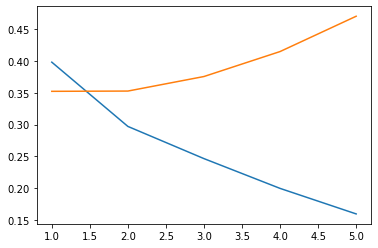

In [17]:
import matplotlib.pyplot as plt
epochs = range(1, len(hy.history['acc']) + 1)
plt.plot(epochs, hy.history['loss'])
plt.plot(epochs, hy.history['val_loss'])

In [21]:
from tensorflow.keras.models import load_model
loaded_model = load_model('best_m1.h5')
loaded_model.evaluate(tt_x,tt_y)[1]

1805/1805 [==============================] - 33s 18ms/step - loss: 0.3528 - acc: 0.8458


0.845836877822876